### Housing price prediction model

#### Sections
- Data preparation
- Feature Engineering
- Training
- Evaluation
- Prediction

In [1]:
# Imports

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_full = pd.read_csv('../../../Projects/kaggle/data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../../../Projects/kaggle/data/house-prices-advanced-regression-techniques/test.csv')

print("Data shape: {train} training obs and {test} testing obs".format(train=train_full.shape, test=test.shape))

Data shape: (1460, 81) training obs and (1459, 80) testing obs


In [3]:
train_full.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# test.info()

In [5]:
test_missing_counts = pd.DataFrame(test.isna().sum(), columns=['Count']).sort_values(by=['Count'], ascending=False)
test_missing_cols = test_missing_counts.loc[test_missing_counts['Count'] > 0.1 * test.shape[0]].index.tolist()

test_missing_cols

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

In [6]:
for data in (test, train_full):
    data.drop(test_missing_cols, axis=1, inplace=True)
# train_full.info()

In [7]:
for c in train_full.select_dtypes(include=['object']).columns:
    if train_full[c].isna().sum():
        print("\n{column}:\n".format(column=c))
        print(train_full[c].value_counts())


MasVnrType:

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

BsmtQual:

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

BsmtCond:

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

BsmtExposure:

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

BsmtFinType1:

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

BsmtFinType2:

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Electrical:

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

GarageType:

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

GarageFinish:

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

GarageQual:

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Nam

In [8]:
X = train_full.drop(['SalePrice', 'Id'], axis=1)
y = train_full.SalePrice.copy()

In [9]:
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

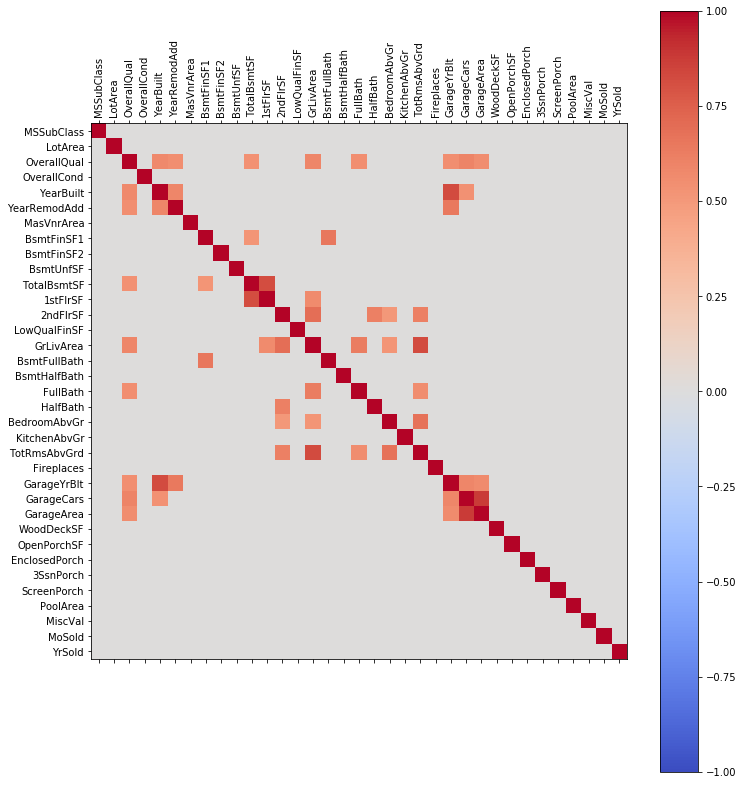

In [10]:
%matplotlib inline

X_num = X[numeric_cols].copy()
X_cat = X[cat_cols].copy()

# correlations - between predictors & with response
X_num_corr = X_num.corr()
X_num_corr = X_num_corr[abs(X_num_corr) > 0.5].fillna(value=0, axis=1)

fig = plt.figure(figsize=(12,14))
ax = fig.add_subplot(111)
cax = ax.matshow(X_num_corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = range(0,len(X_num.columns))
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X_num.columns)
ax.set_yticklabels(X_num.columns)
plt.show()

**Some observations from the correlation heatmap**

- `OverallQual` is correlated with `YearBuilt`, `YearRemodAdd`, `TotalBsmtSF`, `GrLivArea`, `FullBath`, `GarageYrBlt`, `GarageCars`, `GarageArea`
- `YearBuilt` is correlated with `GarageCars`, `GarageArea`, etc
- `TotalBsmtSF` is correlated with `BsmtFinSF1`
- `1stFlrSF` and `2ndFlrSF` are correlated
- `2ndFlrSF` is inturn correlated with `BedroomAbvGrd` and `TotalRmsAbvGrd`
- `GrLivArea` is correlated with `1stFlrSF`, `2ndFlrSF`, `FullBath`, `BedroomAbvGrd` and `TotalRmsAbvGrd`
- `GarageYrBlt`, `GarageCars`, `GarageArea` are all correlated to eachother

In [11]:
X_num_corr_y = X_num.corrwith(y)
X_num_corr_y[abs(X_num_corr_y) > 0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
dtype: float64

**Observations from above correlation series**
- Above predictors are highly correlated with the response
- However, among these:
    - `OverallQual` is correlated with `YearBuilt`, `YearRemodAdd`, `TotalBsmtSF`, `GrLivArea`, `FullBath`, `GarageCars`
    - `GarageArea` and `GarageCars` are correlated
    
- We would therefore go ahead with only the following predictors:
    - `OverallQual`
    - `1stFlrSF`
    - `TotRmsAbvGrd`

In [12]:
X_cat = X[cat_cols].copy()
X_cat.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [13]:
for c in cat_cols:
    print("{col} - {cat}".format(col=c,cat=len(X_cat[c].value_counts().index)))

MSZoning - 5
Street - 2
LotShape - 4
LandContour - 4
Utilities - 2
LotConfig - 5
LandSlope - 3
Neighborhood - 25
Condition1 - 9
Condition2 - 8
BldgType - 5
HouseStyle - 8
RoofStyle - 6
RoofMatl - 8
Exterior1st - 15
Exterior2nd - 16
MasVnrType - 4
ExterQual - 4
ExterCond - 5
Foundation - 6
BsmtQual - 4
BsmtCond - 4
BsmtExposure - 4
BsmtFinType1 - 6
BsmtFinType2 - 6
Heating - 6
HeatingQC - 5
CentralAir - 2
Electrical - 5
KitchenQual - 4
Functional - 7
GarageType - 6
GarageFinish - 3
GarageQual - 5
GarageCond - 5
PavedDrive - 3
SaleType - 9
SaleCondition - 6


In [14]:
# Crosstab analysis - doesn't make sense
salePrice_qualified = pd.cut(y, [0, np.percentile(y, 25), np.percentile(y, 75), np.max(y)], labels=['low', 'medium', 'high'])

for c1 in cat_cols:
    print(pd.crosstab(index=X_cat[c1],columns=salePrice_qualified))

SalePrice  low  medium  high
MSZoning                    
C (all)      9       1     0
FV           0      37    28
RH           6      10     0
RL         212     613   326
RM         138      72     8
SalePrice  low  medium  high
Street                      
Grvl         4       1     1
Pave       361     732   361
SalePrice  low  medium  high
LotShape                    
IR1         58     253   173
IR2          1      19    21
IR3          1       4     5
Reg        305     457   163
SalePrice    low  medium  high
LandContour                   
Bnk           26      31     6
HLS            7      17    26
Low            6      13    17
Lvl          326     672   313
SalePrice  low  medium  high
Utilities                   
AllPub     365     732   362
NoSeWa       0       1     0
SalePrice  low  medium  high
LotConfig                   
Corner      69     123    71
CulDSac      3      50    41
FR2          9      28    10
FR3          1       2     1
Inside     283     530   239
Sa

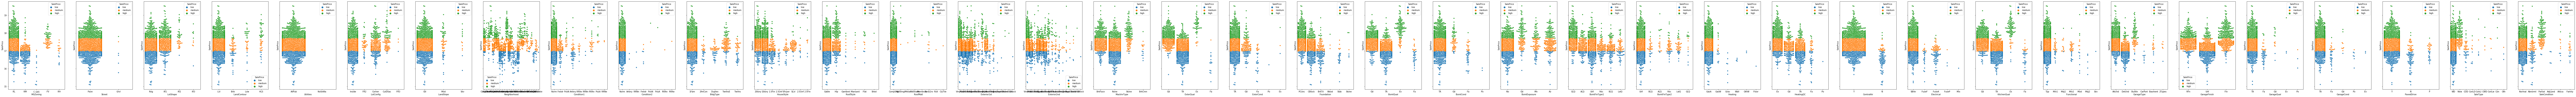

In [24]:
%matplotlib inline
fig, axs = plt.subplots(1, len(X_cat.columns), sharey=True, figsize=(228,8))

for pos, col in enumerate(X_cat.columns):
   sns.swarmplot(col, np.log2(y), hue=salePrice_qualified, data=X_cat, ax=axs[pos])

plt.show()


**Rough observations from `crosstab` & `visualizations`:**
- Useful attributes (Low factor)
    - `MSZoning`, `ExterQual`, `MasVnrType`, `HeatingQC`, `BsmtQual`,`KitchenQual`, `GarageType`, `SaleType`
- NO Useful attributes with high factor


In [16]:
# X_subset = X.drop([cols for cols in X_num.columns if cols not in ['OverallQual', '1stFlrSF', 'TotRmsAbvGrd']],
#                   axis=1)

X_subset = X.drop([cols for cols in X.columns if cols not in ['OverallQual', 'YearBuilt', 'YearRemodAdd',
                                                                  'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
                                                                  'FullBath', 'TotRmsAbvGrd', 'GarageCars',
                                                                  'GarageArea', 'MSZoning','ExterQual',
                                                                  'MasVnrType', 'HeatingQC', 'BsmtQual', 'KitchenQual',
                                                                  'GarageType', 'SaleType']], axis=1)


sub_numeric_cols = X_subset.select_dtypes(include=['float64', 'int64']).columns
sub_cat_cols = X_subset.select_dtypes(include=['object']).columns

X_subset.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageType,GarageCars,GarageArea,SaleType
0,RL,7,2003,2003,BrkFace,Gd,Gd,856,Ex,856,1710,2,Gd,8,Attchd,2,548,WD
1,RL,6,1976,1976,None,TA,Gd,1262,Ex,1262,1262,2,TA,6,Attchd,2,460,WD
2,RL,7,2001,2002,BrkFace,Gd,Gd,920,Ex,920,1786,2,Gd,6,Attchd,2,608,WD
3,RL,7,1915,1970,None,TA,TA,756,Gd,961,1717,1,Gd,7,Detchd,3,642,WD
4,RL,8,2000,2000,BrkFace,Gd,Gd,1145,Ex,1145,2198,2,Gd,9,Attchd,3,836,WD


In [17]:
"""
preprocess_numeric = ColumnTransformer(transformers=[
    ('num_preproc', Pipeline(steps=[
        ('numeric_imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), sub_numeric_cols)], remainder='passthrough')

preprocess_cat = ColumnTransformer(transformers=[
    ('cat_preproc', Pipeline(steps=[
        ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder())
    ]), sub_cat_cols)], remainder='passthrough')

"""

preprocess = ColumnTransformer(transformers=[
    ('num_preproc', Pipeline(steps=[
        ('numeric_imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), sub_numeric_cols),
    ('cat_preproc', Pipeline(steps=[
        ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder())
    ]), sub_cat_cols)
], remainder='passthrough')



In [18]:
X_preproc = preprocess.fit_transform(X_subset)
X_test_preproc = preprocess.transform(test)

/home/saileshg/sailspace/dev/py3mlenv/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [19]:
# baseline = RandomForestRegressor(max_depth=3)
# baseline.fit(X_preproc, y)
# y_pred = baseline.predict(X_test_preproc)
# y_pred[:5]

In [20]:
# Fine-tuning the model
param_grid = {"n_estimators":[100,200,300,400,500], "max_depth":[2,3], "max_features":["auto","sqrt","log2"]}
forest_finetuned = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, n_jobs=-1, cv=5)

In [21]:
forest_finetuned.fit(X_preproc, y)
y_pred = forest_finetuned.predict(X_test_preproc)

In [22]:
# Save test predictions to file
output = pd.DataFrame({"Id": test.Id, "SalePrice": y_pred})
output.to_csv("house_price_kaggle_submission.csv", index=False)